In [3]:
from orphics import sehgal
import numpy as np
import os
import matplotlib.pyplot as plt
from pixell import enmap, curvedsky, utils, enplot
import healpy as hp

%matplotlib inline
%load_ext autoreload
%autoreload 2

kappa


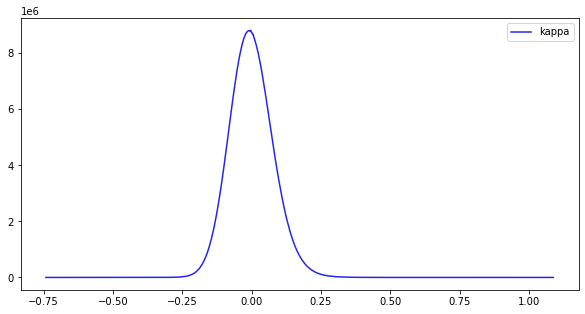

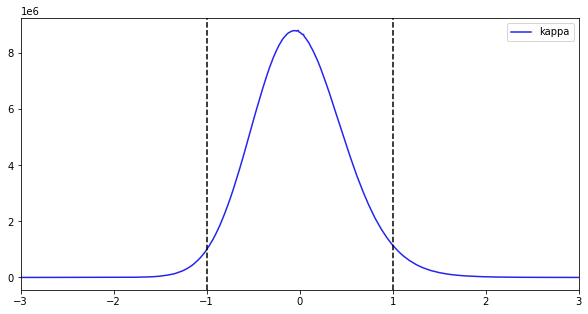

ir_pts


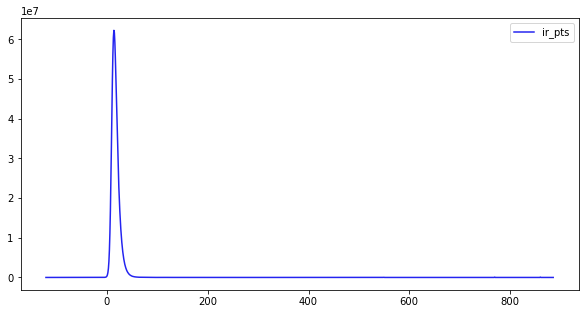

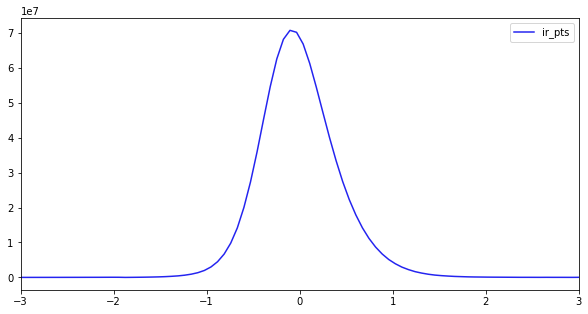

ksz


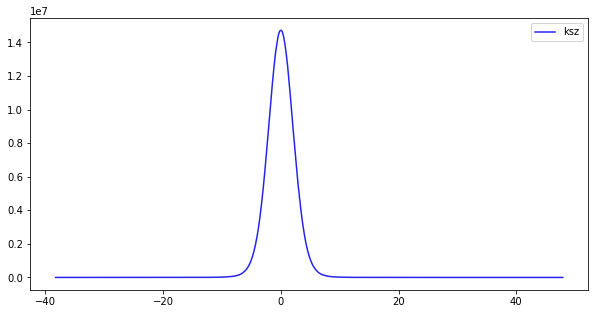

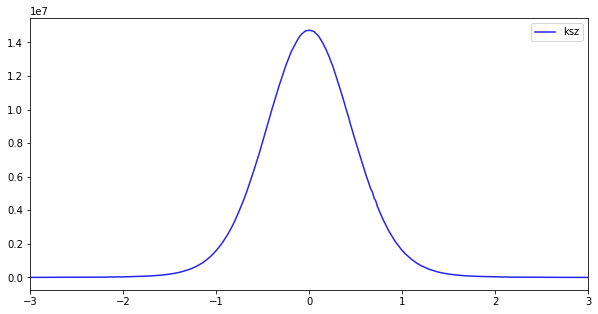

rad_pts


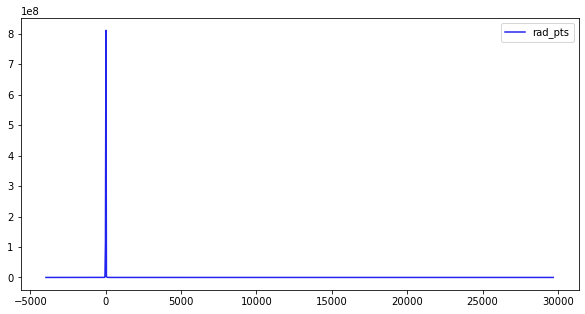

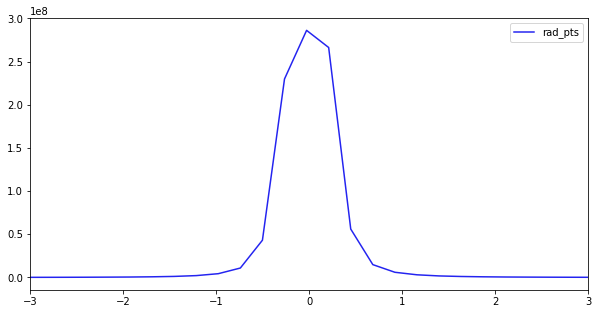

tsz


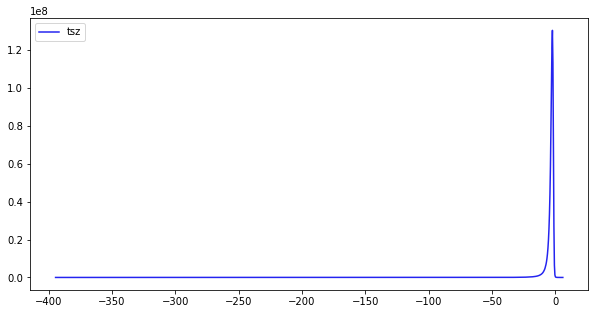

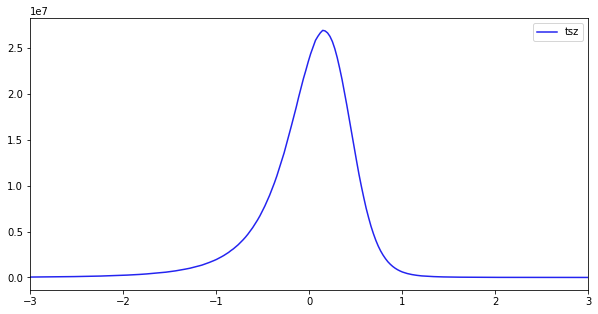

In [5]:
sehgal_dir = "/home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/inputs/microwaveSky"
SEHGAL10 = sehgal.SehgalSky2010(path=sehgal_dir, data_type='enmap')

hists_org = {}
hists_norm = {}
norm_info = {}
dfactor = 2

def power_normalize(emap, pos_pow, neg_pow):
    temp = emap.copy()
    loc = np.where(emap>=0)
    temp[loc] = temp[loc]**pos_pow
    loc = np.where(emap<0)
    temp[loc] = -1*np.abs(temp[loc])**neg_pow
    return temp

def mean_normalize(emap):
    temp = emap.copy()
    temp = temp - np.mean(temp)
    return temp

def minmax_normalize(emap):
    max_val, min_val = emap.max(), emap.min()
    return (emap)/(max_val-min_val)

def z_normalize(emap, zfact = 2):
    mean, std = emap.mean(), emap.std()
    
    return (emap-mean)/(std*zfact), (mean, std)

rfs = {"kappa": SEHGAL10.get_kappa,
       "ksz": SEHGAL10.get_ksz,
       "tsz": SEHGAL10.get_tsz,
       "rad_pts": SEHGAL10.get_radio,
       "ir_pts": SEHGAL10.get_cib
      }

freq_idx = 148
ns = {"kappa": z_normalize,
      "ksz": z_normalize,
      "ir_pts": lambda x: z_normalize(power_normalize(x, 1/2, 1)),
      "rad_pts": lambda x: z_normalize(power_normalize(x, 0.7, 0.7), 2),
      "tsz": lambda x: z_normalize(power_normalize(x, 1, 1/4)),
     }

for compt_idx in ['kappa']:
    print(compt_idx)
    emap = rfs[compt_idx]()

    hist, bins = np.histogram(emap.flatten(), bins=1024)
    fig = plt.figure(figsize=(10, 5))
    hists_org[compt_idx] = (hist, bins)
    bin_center = (bins[:-1]+bins[1:])/2.
    plt.plot(bin_center, hist, label=compt_idx)
    plt.legend()
    plt.show()
    
    emap, norm_info[compt_idx] = ns[compt_idx](emap)
    hist, bins = np.histogram(emap.flatten(), bins=1024)
    fig = plt.figure(figsize=(10, 5))
    hists_norm[compt_idx] = (hist, bins)
    bin_center = (bins[:-1]+bins[1:])/2.
    plt.plot(bin_center, hist, label=compt_idx)
    plt.axvline(x=1, ls="--", color="k")
    plt.axvline(x=-1, ls="--", color="k")
    plt.legend()
    plt.xlim(-3,3)
    plt.show()
    




for compt_idx in ['ir_pts', "ksz", "rad_pts", "tsz"]:
#for compt_idx in ['ir_pts', "rad_pts", "tsz"]:
    print(compt_idx)
    #if compt_idx != "rad_pts": continue
    emap = rfs[compt_idx](freq_idx)#
    #emap= enmap.downgrade(rfs[compt_idx](freq_idx),4)
    
    hist, bins = np.histogram(emap.flatten(), bins=1024)
    fig = plt.figure(figsize=(10, 5))
    hists_org[compt_idx] = (hist, bins)
    bin_center = (bins[:-1]+bins[1:])/2.
    plt.plot(bin_center, hist, label=compt_idx)
    plt.legend()
    plt.show()
    
    emap, norm_info[compt_idx] = ns[compt_idx](emap)
    hist, bins = np.histogram(emap.flatten(), bins=1024)
    fig = plt.figure(figsize=(10, 5))
    hists_norm[compt_idx] = (hist, bins)
    bin_center = (bins[:-1]+bins[1:])/2.
    plt.xlim(-3,3)
    plt.plot(bin_center, hist, label=compt_idx)
    plt.axvline(x=1, ls="--", color="k")
    plt.axvline(x=-1, ls="--", color="k")
    plt.legend()
    plt.show()



In [12]:
import pickle

with open("hists_org.pkl", "wb") as handle:
    pickle.dump(hists_org, handle)
    
with open("hists_norm.pkl", "wb") as handle:
    pickle.dump(hists_norm, handle)

with open("norm_info.pkl", "wb") as handle:
    pickle.dump(norm_info, handle)

6.994690813587983


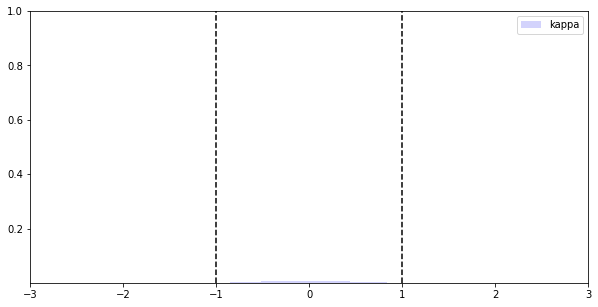

12.285398208654877


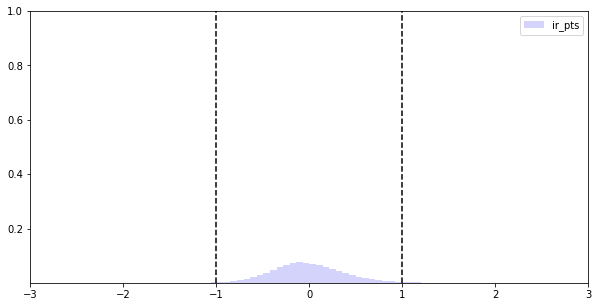

10.542550800303932


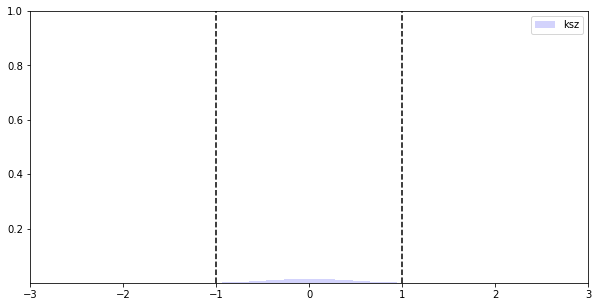

195.12392651775306


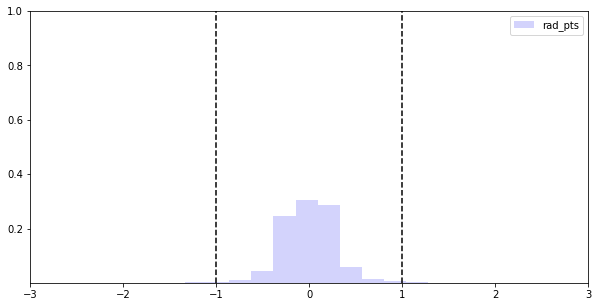

18.730866101601073


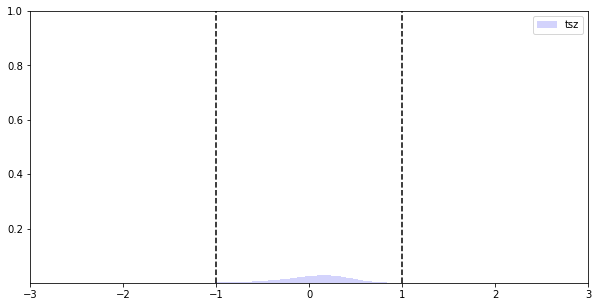

In [16]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math

#mu = 0
#variance = 1
#sigma = math.sqrt(variance)
#x = np.linspace(mu - 2*sigma, mu + 2*sigma, 100)

hists_norm = pickle.load(open("hists_norm.pkl", "rb"))


for key in hists_norm.keys():
    fig = plt.figure(figsize=(10, 5))
    (hist, bins) = hists_norm[key]
    nsum = np.sum(hist)
    bin_center = (bins[:-1]+bins[1:])/2.
    width = (bins[:-1]-bins[1:])[0]
    plt.bar(bin_center, hist/nsum, width, label=key, alpha=0.2)
    plt.xlim(-3,3)
    plt.legend()
    plt.ylim(1e-3,1)
    plt.axvline(x=1, ls="--", color="k")
    plt.axvline(x=-1, ls="--", color="k")
    print(np.max(bin_center))
    #plt.yscale("log")
    plt.show()
    
    


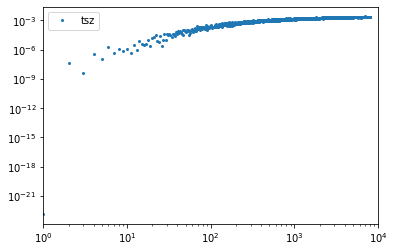

In [58]:
sehgal_dir = "/home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/inputs/microwaveSky"
spec_dir = "/home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/inputs/specs"

shape, wcs = enmap.fullsky_geometry(res=0.5*utils.arcmin)
template = enmap.zeros(shape, wcs)

fig = plt.figure()
freq_idx = 148
fgs = ["lensedcmb", "skymap"]
for fg_idx in fgs:
    alm_file = os.path.join(sehgal_dir, "148_%s_alm.fits"%fg_idx)
    enmap_file = os.path.join(sehgal_dir, "148_%s_enmap.fits"%fg_idx)
    spec_file = os.path.join(spec_dir, "148_%s_dls.npy"%fg_idx)
    alm = np.complex128(hp.read_alm(alm_file))
    fgmap = template.copy()
    fgmap = curvedsky.alm2map(alm, fgmap)
    cl = hp.alm2cl(alm)*sehgal.jysr2thermo(148)**2
    l = np.arange(len(cl))
    l_fact = l*(l+1)/(2*np.pi)
    plt.plot(l, l_fact*cl, label=fg_idx, ls="", marker="o"
            , markersize=2)
    specs = np.zeros((8000+1, 2))
    specs[:,0] = l
    specs[:,1] = l_fact*cl
    np.save(spec_file, specs)
    enmap.write_map(enmap_file, fgmap)
    
plt.legend()
plt.xlim(1, 1e4)
#plt.ylim(1e-2, 1e4)
plt.xscale("log")
plt.yscale("log")
plt.show()

fig = plt.figure()
freq_idx = 148
fgs = ['ir_pts', "ksz", "rad_pts", "tsz", "lensed"]
for fg_idx in fgs:
    alm_file = os.path.join(sehgal_dir, "148_%s_alm.fits"%fg_idx)
    enmap_file = os.path.join(sehgal_dir, "148_%s_enmap.fits"%fg_idx)
    spec_file = os.path.join(spec_dir, "148_%s_dls.npy"%fg_idx)
    alm = np.complex128(hp.read_alm(alm_file))
    fgmap = template.copy()
    fgmap = curvedsky.alm2map(alm, fgmap)
    cl = hp.alm2cl(alm)*sehgal.jysr2thermo(148)**2
    l = np.arange(len(cl))
    l_fact = l*(l+1)/(2*np.pi)
    plt.plot(l, l_fact*cl, label=fg_idx, ls="", marker="o"
            , markersize=2)
    specs = np.zeros((8000+1, 2))
    specs[:,0] = l
    specs[:,1] = l_fact*cl
    np.save(spec_file, specs)
    enmap.write_map(enmap_file, fgmap)
    
plt.legend()
plt.xlim(1, 1e4)
plt.ylim(1e-2, 1e4)
plt.xscale("log")
plt.yscale("log")
plt.show()

fig = plt.figure()

alm_file = os.path.join(sehgal_dir, "kappa_alm.fits")
enmap_file = os.path.join(sehgal_dir, "kappa_enmap.fits")
spec_file = os.path.join(spec_dir, "kappa_cls.npy")
alm = np.complex128(hp.read_alm(alm_file))
fgmap = template.copy()
fgmap = curvedsky.alm2map(alm, fgmap)
cl = hp.alm2cl(alm)
l = np.arange(len(cl))
plt.plot(l, l_fact*cl, label="kappa", ls="", marker="o"
        , markersize=2)
specs = np.zeros((8000+1, 2))
specs[:,0] = l
specs[:,1] = cl
np.save(spec_file, specs)
enmap.write_map(enmap_file, fgmap)
    
plt.legend()
plt.xlim(1, 1e4)
#plt.ylim(1e-2, 1e4)
plt.xscale("log")
plt.yscale("log")
plt.show()

In [1]:
from orphics import maps as omaps